## Testing for matrices script 

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Plot pairwise CMIC and generational distance, incorporating uncertainty due to
oceanographic variability
@author: Noam Vogt-Vincent
"""

import sys
sys.path.insert(0, '../VogtVincent/SIM/')
from datetime import datetime, timedelta
from connectivity import compute_CMIC
from tqdm import tqdm
from SECoW import Matrix
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import cmasher as cmr

In [2]:
int(sys.argv[2])

ValueError: invalid literal for int() with base 10: '/Users/jiaruizhou/.local/share/jupyter/runtime/kernel-0a8b38d4-a070-488f-a91d-78a66689e3da.json'

#### Note to self: 
- assign AV as `bio_code=AV`
- Replace with desire ie`n_gen_max = 10` 
- retention_mod = 1.0
- change study year: `year_list = np.arange(1993, 2020)`

In [4]:
###############################################################################
# PARAMETERS ##################################################################
###############################################################################

# Bio code
bio_code = 'AV' #sys.argv[1]

# Number of generations
n_gen_max = 50 #int(sys.argv[2])   # Number of generations to simulate

# Number of iterations to test
n_its = 1000

# Retention modifier (divide non-retentive connections by this)
try:
    retention_mod = float(1.0)#sys.argv[3])
except:
    retention_mod = 1

# Percentiles to use
pct_bnd = [0.025, 0.975]

# Permitted years and days
year_list = np.arange(1997, 1998)
day_list = np.concatenate(
    (np.arange(1, 91), np.arange(274, 366)))  # i.e. JFM/OND

# DIRECTORIES
dirs = {}
dirs['root'] = os.getcwd() + '/../'
dirs['matrix'] = dirs['root'] + 'MATRICES/' + str(bio_code) + '/'
dirs['grid'] = dirs['root'] + 'GRID_DATA/'
dirs['fig'] = dirs['root'] + 'FIGURES/Matrices/' + str(bio_code) + '/'

# FILE-HANDLES
fh = {}
fh['matrix'] = dirs['matrix'] + 'WINDS_flux_src_grp_' + bio_code + '.nc'
fh['site_list'] = dirs['grid'] + 'site_reference_grp_reordered.xlsx'

In [5]:
###############################################################################
# PREPROCESS DATA #############################################################
###############################################################################

print('--------------------------------')
print('Preprocessing matrices...')
print('--------------------------------')

# Load SECoW matrix
with xr.open_dataset(fh['matrix']) as file:
    matrix = Matrix(file, bio_code)
    matrix.label(fh['site_list'])

    grp_list = list(matrix.country_dict.keys())

    # Normalise matrix by source sites (for backward CMIC)
    I = xr.ones_like(matrix.matrix.ns[:, :, 0].drop('time'))
    I = I.where(I.source_group == I.sink_group).fillna(0.)

    B = xr.where(matrix.matrix.ns.source_group != matrix.matrix.ns.sink_group,
                 matrix.matrix.ns/retention_mod, matrix.matrix.ns)
    B = B/B.sum(dim='source_group')
    B_mean = matrix.matrix.ns[:, :, matrix.matrix.time.dt.dayofyear.isin(
        day_list)].mean(dim='time')
    B_mean = B_mean/B_mean.sum(dim='source_group')

    # For conservation, the sum of incoming fluxes must be equal to one so, if
    # there are no sources for a time slice, assume self-recruitment.
    B = xr.where(np.isnan(B), I, B)
    # Should be redundant, but JIC
    B_mean = xr.where(np.isnan(B_mean), I, B_mean)

    # Transpose (B matrix in this formulation is transposed)
    B = B.transpose('sink_group', 'source_group', 'time')
    B_mean = B_mean.transpose('sink_group', 'source_group')

--------------------------------
Preprocessing matrices...
--------------------------------


/tmp/ipykernel_1970504/2801881024.py:17: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  I = xr.ones_like(matrix.matrix.ns[:, :, 0].drop('time'))


In [6]:
###############################################################################
# PROCESS DATA ################################################################
###############################################################################

print('')
print('--------------------------------')
print('Processing matrices...')
print('--------------------------------')

# 1. Iterate over the following:
# 1.1. Pick n random years
# 1.2. Pick a random day within the spawning season for each year
# 1.3. Compute CMIC across those years
# 1.4. Convert to number of generations (50% threshold)
# 2. Reduce matrix to sampled sites only, taking the mean across multi-cell sites if required
# 3. Compute percentiles

np.random.seed(27183)

# Create output matrix
gen_dist_all = xr.DataArray(data=np.zeros((len(B.source_group),
                                           len(B.sink_group),
                                           n_its)),
                            dims=['source_group', 'sink_group', 'iteration'],
                            coords=dict(source_group=(['source_group'], B.source_group.data),
                                        sink_group=(['sink_group'],
                                                    B.sink_group.data),
                                        iteration=(['iteration'], np.arange(n_its))))

for it in tqdm(range(n_its), total=n_its):
    # Get random years
    random_years = np.random.choice(year_list, size=(n_gen_max,), replace=True)

    # Get random days
    random_days = np.random.choice(day_list, size=(n_gen_max,), replace=True)

    # Get string of dates
    random_dates = [datetime(year=year, month=1, day=1) + timedelta(days=int(day)-1)
                    for year, day in zip(random_years, random_days)]
    random_dates = [str(date.year) + '-' + str(date.month) +
                    '-' + str(date.day) for date in random_dates]

    # Extract subset connectivity matrix
    B_sub = B.sel(time=random_dates)

    # Compute CMIC
    _cmic = compute_CMIC(B_sub, full=True)

    # Extract number of years corresponding to 50% CMIC and save
    # Add an exception for all-zeros (return maximum)
    _cmic.loc[:, :, n_gen_max] = 1.
    gen_dist_all.loc[:, :, it] = np.argmax(_cmic.values >= 0.5, axis=-1) + 1

# Compute the median across all iterations
gen_dist_median = gen_dist_all.quantile(0.5, dim='iteration')
gen_dist_variance = (gen_dist_all.quantile(0.975, dim='iteration') -
                     gen_dist_all.quantile(0.025, dim='iteration'))/gen_dist_median

print('90th percentile generational distance: ' + str(float(gen_dist_median.quantile(0.90))))
print('95th percentile generational distance: ' + str(float(gen_dist_median.quantile(0.95))))
print('99th percentile generational distance: ' + str(float(gen_dist_median.quantile(0.99))))


--------------------------------
Processing matrices...
--------------------------------


100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s]


90th percentile generational distance: 50.0
95th percentile generational distance: 50.0
99th percentile generational distance: 50.0



--------------------------------
Plotting data...
--------------------------------


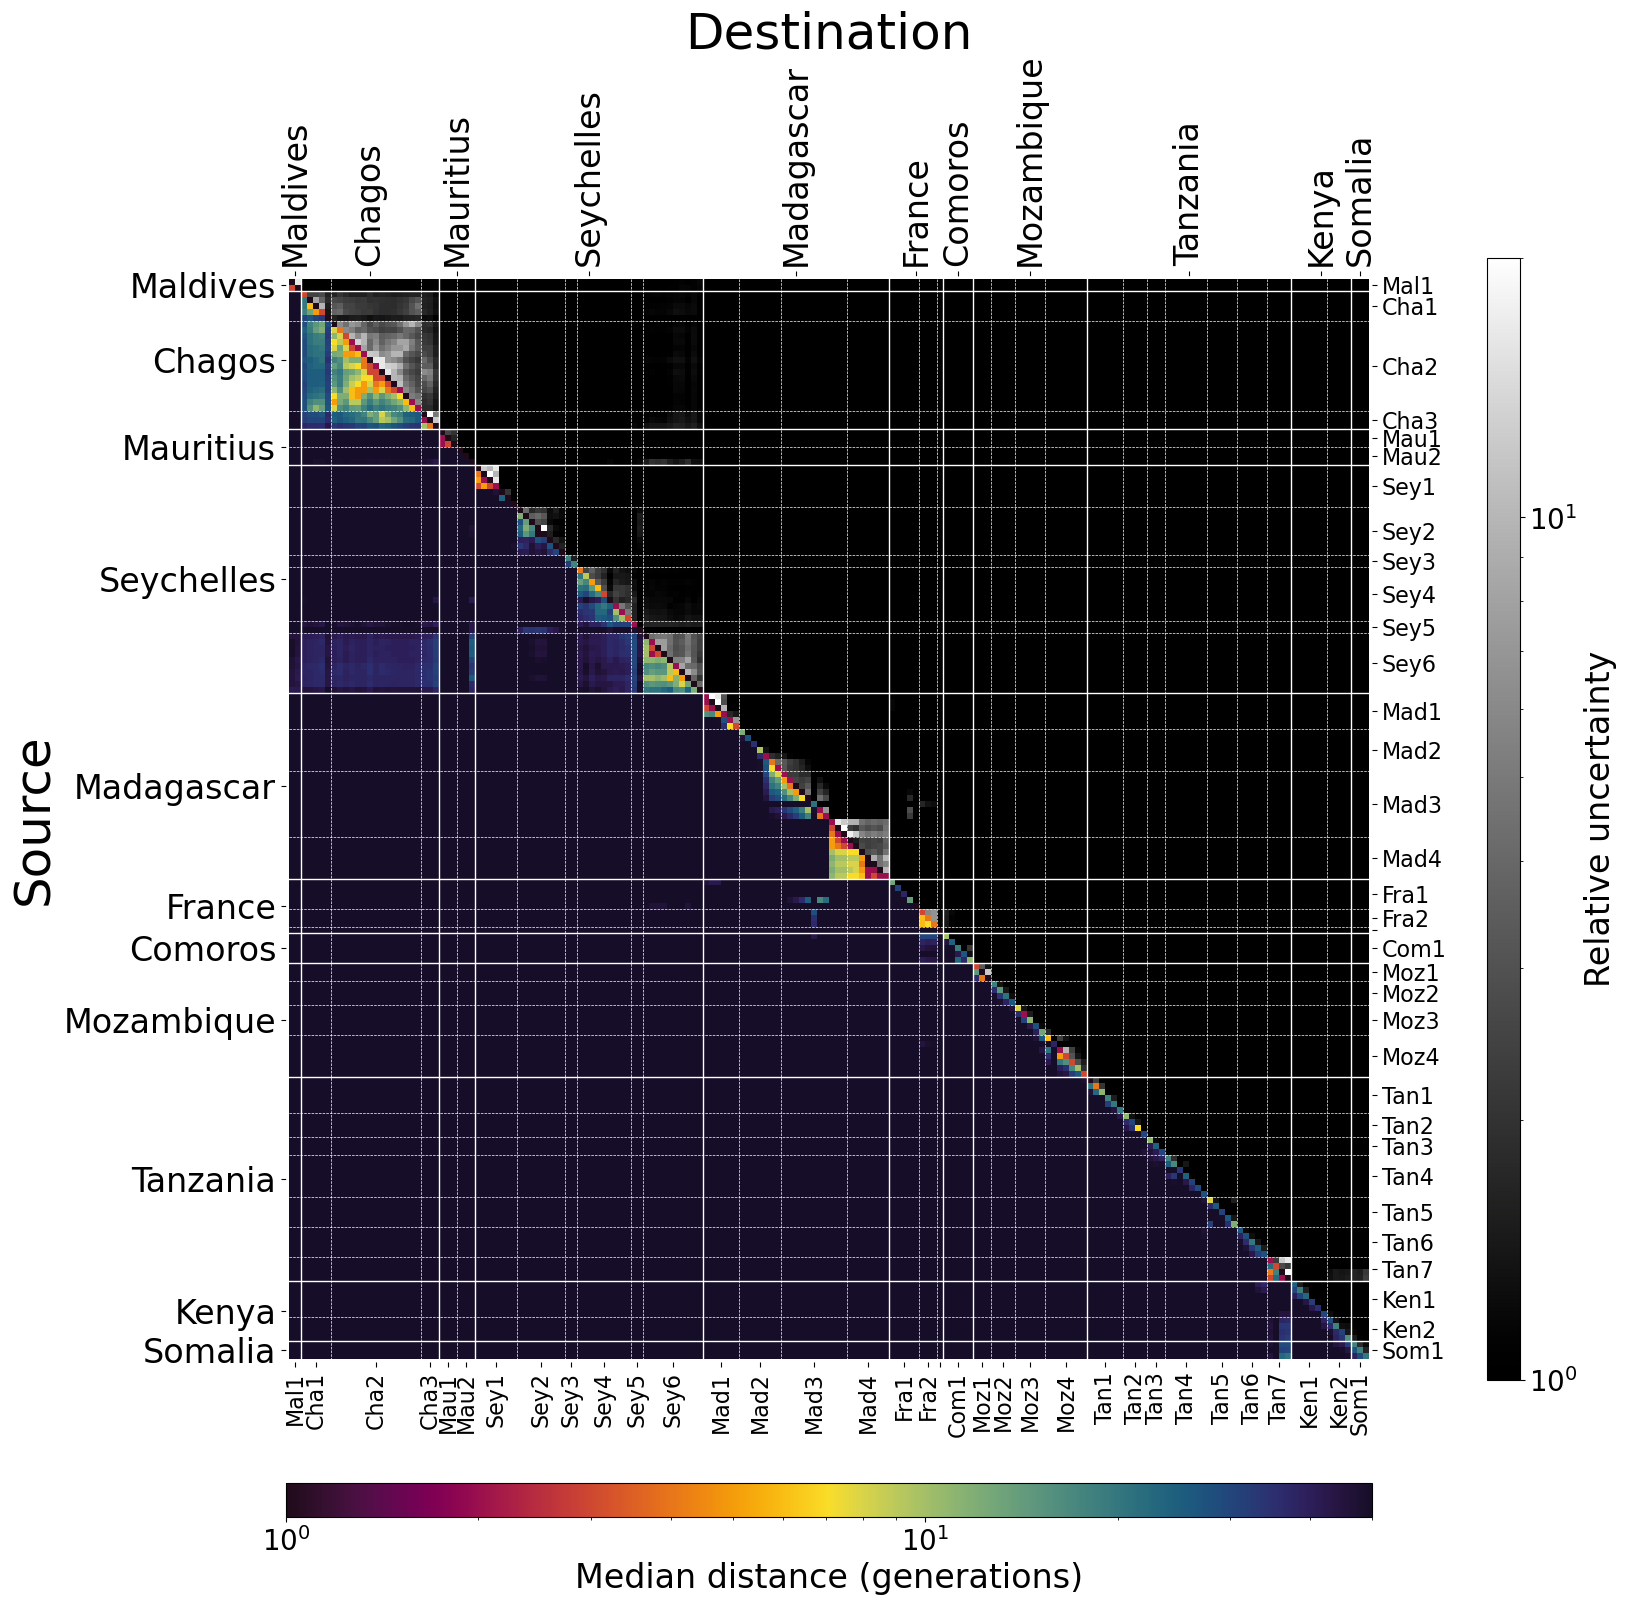

In [7]:
###############################################################################
# PLOT DATA ###################################################################
###############################################################################

print('')
print('--------------------------------')
print('Plotting data...')
print('--------------------------------')

axis_bnd = np.arange(len(gen_dist_median.source_group.values)+1) + 0.5

# Get a lower and upper triangular mask
mask_A = np.nan*np.ones_like(gen_dist_median)
mask_B = np.nan*np.ones_like(gen_dist_median)
_a, _b = np.meshgrid(np.arange(len(axis_bnd)-1), np.arange(len(axis_bnd)-1))
mask_A[_a <= _b] = 1
mask_B[_a > _b] = 1

# Get a list of country border lines
country_border_pos = []
for country in matrix.country_list[1:]:
    country_border_pos.append(matrix.country_bnds[country]['i0'])

country_tick_pos = []
country_tick_label = []

for country in matrix.country_list:
    if matrix.country_bnds[country]['nsites'] > 1:
        country_tick_pos.append(matrix.country_bnds[country]['mp'])
        country_tick_label.append(country)

L1_border_pos = []
L1_border_pos.append([0])
for L1 in matrix.L1_list[1:]:
    L1_border_pos.append(matrix.L1_bnds[L1]['i0'])

country_border_pos.append(181)

L1_tick_pos = []
L1_tick_label_full = []
L1_tick_label = []

for L1 in matrix.L1_list:
    L1_tick_pos.append(matrix.L1_bnds[L1]['mp'])
    if matrix.L1_bnds[L1]['nsites'] > 1:
        L1_tick_label.append(L1)
    else:
        L1_tick_label.append('')

country_code = {'Maldives': 'Mal', 'Chagos': 'Cha', 'Mauritius': 'Mau', 'Seychelles': 'Sey',
                'Madagascar': 'Mad', 'France': 'Fra', 'Comoros': 'Com', 'Mozambique': 'Moz',
                'Tanzania': 'Tan', 'Kenya': 'Ken', 'Somalia': 'Som'}

L1_country_tick_label_ = [country_code[country_tick_label[np.argmax(country_border_pos > L1_border_pos[i])]] for i in range(len(L1_tick_label))]
L1_country_tick_label = []
ticker = 0

for i in range(len(L1_tick_label)):
    if i > 0:
        if L1_tick_label[i] == '':
            L1_country_tick_label.append('')
        else:
            if L1_country_tick_label_[i] == L1_country_tick_label_[i-1]:
                ticker += 1
            else:
                ticker = 0

            L1_country_tick_label.append(
                L1_country_tick_label_[i] + str(ticker + 1))
    else:
        L1_country_tick_label.append(
            L1_country_tick_label_[i] + str(ticker + 1))

f = plt.figure(constrained_layout=True, figsize=(16.15, 16.0))
gs = GridSpec(2, 2, figure=f, height_ratios=[1, 0.03], width_ratios=[
              1, 0.03], hspace=0.05, wspace=0.05)
ax = []
ax.append(f.add_subplot(gs[0, 0], zorder=2))  # Genetic distance
ax.append(f.add_subplot(gs[0, 0], zorder=1))  # Duplicate axis
ax.append(f.add_subplot(gs[1, 0]))  # Distance CB
ax.append(f.add_subplot(gs[0, 1]))  # Variance CB

# Plot median data
gen_plot = ax[0].pcolormesh(axis_bnd, axis_bnd, mask_A*gen_dist_median,
                            norm=colors.LogNorm(
                                vmin=1e0, vmax=n_gen_max, clip=True),
                            cmap=cmr.pride_r)

# Plot uncertainty
conf_plot = ax[0].pcolormesh(axis_bnd, axis_bnd, mask_B*gen_dist_variance,
                             norm=colors.LogNorm(
                                 vmin=1e0, vmax=2e1, clip=True),
                             cmap=cmr.neutral)

for bndry in country_border_pos:
    ax[0].plot([axis_bnd.min(), axis_bnd.max()],
               [bndry, bndry], 'w-', linewidth=1)
    ax[0].plot([bndry, bndry], [axis_bnd.min(),
               axis_bnd.max()], 'w-', linewidth=1)

for bndry in L1_border_pos:
    ax[0].plot([axis_bnd.min(), axis_bnd.max()], [
               bndry, bndry], 'w--', linewidth=0.5)
    ax[0].plot([bndry, bndry], [axis_bnd.min(),
               axis_bnd.max()], 'w--', linewidth=0.5)

ax[0].set_aspect(1)
ax[0].set_facecolor('w')
ax[0].set_xticks(country_tick_pos)
ax[0].set_xticklabels(country_tick_label, rotation='vertical', fontsize=24,)
ax[0].set_yticks(country_tick_pos)
ax[0].set_yticklabels(country_tick_label, fontsize=24)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].xaxis.tick_top()
ax[0].set_xlim([0, 181])
ax[0].set_ylim([0, 181])
ax[0].invert_yaxis()
ax[0].set_xlabel('Destination', fontsize=36)
ax[0].set_ylabel('Source', fontsize=36)
ax[0].xaxis.set_label_position('top')

ax[1].set_aspect(1)
ax[1].set_xticks(L1_tick_pos)
ax[1].set_xticklabels(L1_country_tick_label, rotation='vertical', fontsize=16,)
ax[1].set_yticks(L1_tick_pos)
ax[1].set_yticklabels(L1_country_tick_label, fontsize=16)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].yaxis.tick_right()
ax[1].set_xlim([0, 181])
ax[1].set_ylim([0, 181])
ax[1].invert_yaxis()

cbar1 = plt.colorbar(gen_plot, cax=ax[2], orientation='horizontal')
cbar1.set_label('Median distance (generations)', size=24)
cbar1.ax.tick_params(axis='x', labelsize=20)

cbar2 = plt.colorbar(conf_plot, cax=ax[3], orientation='vertical')
cbar2.set_label('Relative uncertainty', size=24)
cbar2.ax.tick_params(axis='y', labelsize=20)

r_str = '_r' + str(retention_mod) if retention_mod != 0 else ''

#### Note to self:
Commented out all the 
- plt.savefig
- plt.close()

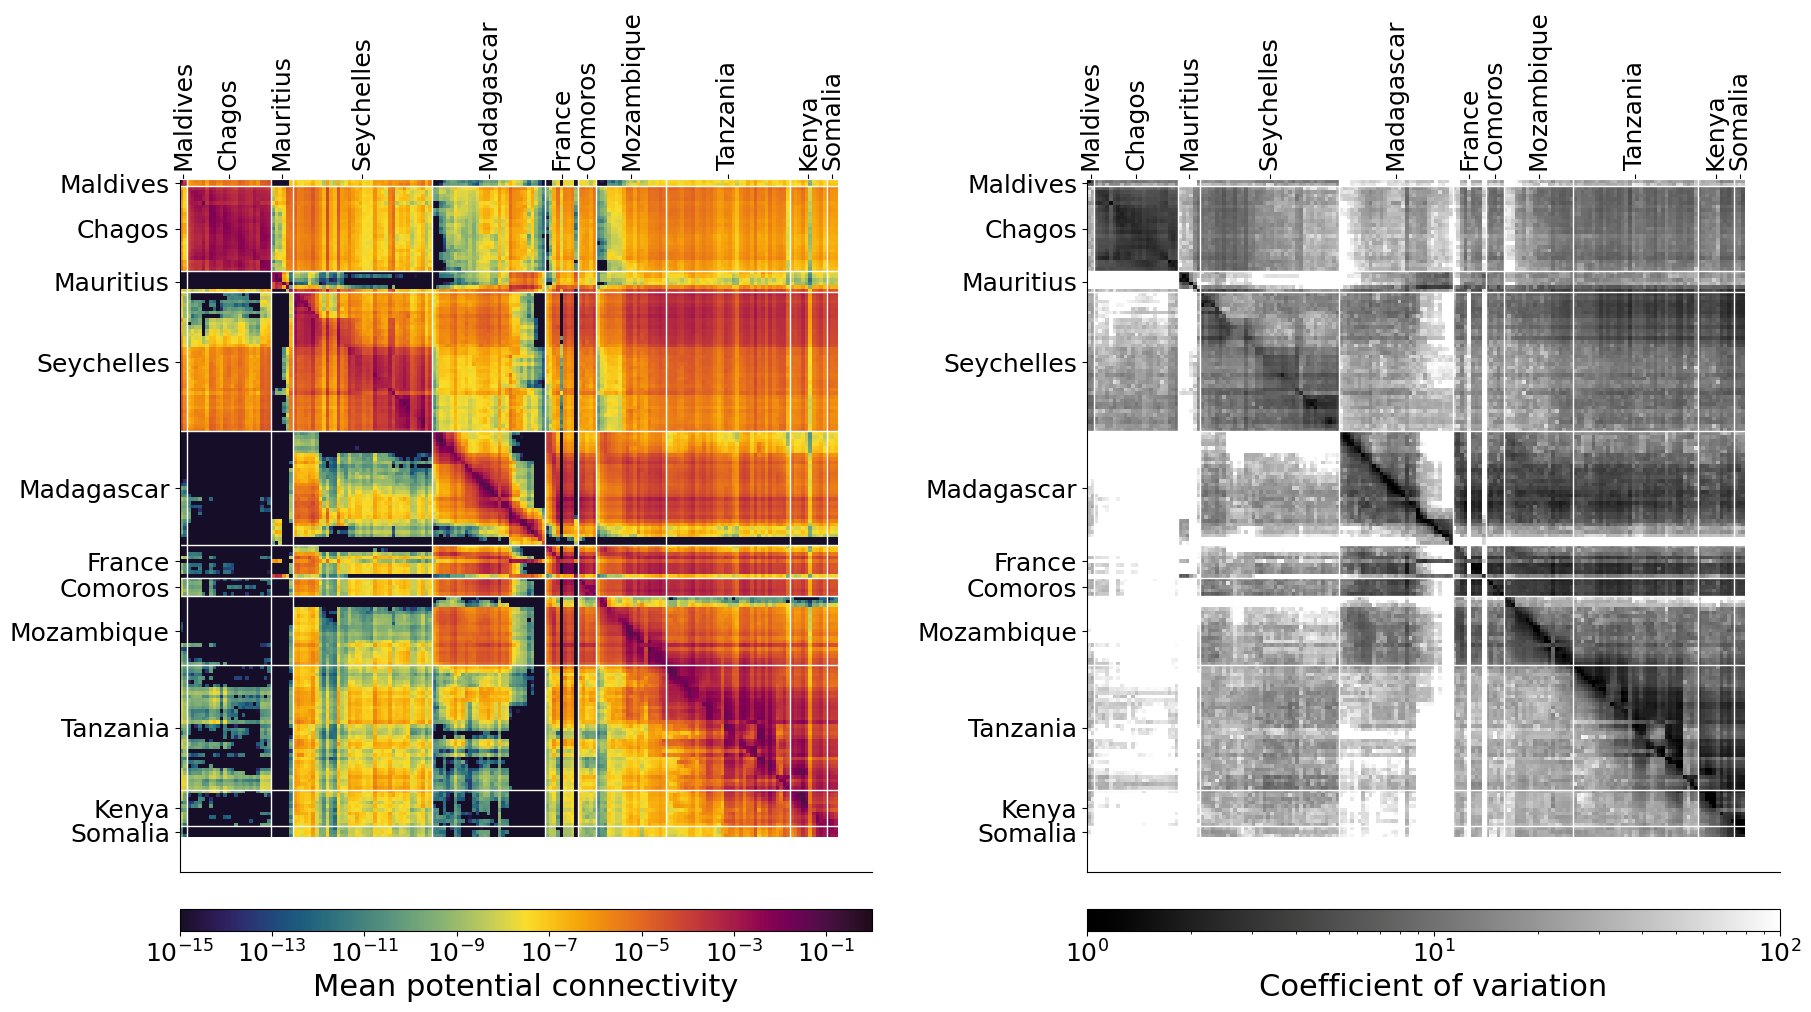

In [8]:
#plt.savefig(dirs['fig'] + bio_code + r_str + '_gen_dist.pdf',
            #bbox_inches='tight', dpi=300)
#plt.close()

# Also export the flux matrix
mean_matrix = (matrix.matrix.ns/matrix.matrix.rc).mean(dim='time')
mean_matrix_mod = mean_matrix.where(mean_matrix > 0).fillna(1)
cv_matrix = (matrix.matrix.ns/matrix.matrix.rc).std(dim='time')/mean_matrix_mod

f = plt.figure(constrained_layout=True, figsize=(18, 10.0))
gs = GridSpec(2, 2, figure=f, height_ratios=[1, 0.03], width_ratios=[
              1, 1], hspace=0.05, wspace=0.05)
ax = []
ax.append(f.add_subplot(gs[0, 0]))  # Mean
ax.append(f.add_subplot(gs[1, 0]))  # Distance CB
ax.append(f.add_subplot(gs[0, 1]))  # CV
ax.append(f.add_subplot(gs[1, 1]))  # CV CB

# Plot mean data
gen_plot = ax[0].pcolormesh(axis_bnd, axis_bnd, mean_matrix,
                            norm=colors.LogNorm(
                                vmin=1e-15, vmax=1e0, clip=True),
                            cmap=cmr.pride)

for bndry in country_border_pos:
    ax[0].plot([axis_bnd.min(), axis_bnd.max()],
               [bndry, bndry], 'w-', linewidth=1)
    ax[0].plot([bndry, bndry], [axis_bnd.min(),
               axis_bnd.max()], 'w-', linewidth=1)

ax[0].set_aspect(1)
ax[0].set_facecolor('w')
ax[0].set_xticks(country_tick_pos)
ax[0].set_xticklabels(country_tick_label, rotation='vertical', fontsize=18,)
ax[0].set_yticks(country_tick_pos)
ax[0].set_yticklabels(country_tick_label, fontsize=18)
ax[0].invert_yaxis()
ax[0].spines['right'].set_color('w')
ax[0].spines['top'].set_color('w')
ax[0].xaxis.tick_top()

# Plot CV
conf_plot = ax[2].pcolormesh(axis_bnd, axis_bnd, cv_matrix,
                             norm=colors.LogNorm(vmin=1e0, vmax=1e2),
                             cmap=cmr.neutral)

for bndry in country_border_pos:
    ax[2].plot([axis_bnd.min(), axis_bnd.max()],
               [bndry, bndry], 'w-', linewidth=1)
    ax[2].plot([bndry, bndry], [axis_bnd.min(),
               axis_bnd.max()], 'w-', linewidth=1)

ax[2].set_aspect(1)
ax[2].set_facecolor('w')
ax[2].set_xticks(country_tick_pos)
ax[2].set_xticklabels(country_tick_label, rotation='vertical', fontsize=18,)
ax[2].set_yticks(country_tick_pos)
ax[2].set_yticklabels(country_tick_label, fontsize=18)
ax[2].invert_yaxis()
ax[2].spines['right'].set_color('w')
ax[2].spines['top'].set_color('w')
ax[2].xaxis.tick_top()

cbar1 = plt.colorbar(gen_plot, cax=ax[1], orientation='horizontal')
cbar1.set_label('Mean potential connectivity', size=22)
cbar1.ax.tick_params(axis='x', labelsize=18)

cbar2 = plt.colorbar(conf_plot, cax=ax[3], orientation='horizontal')
cbar2.set_label('Coefficient of variation', size=22)
cbar2.ax.tick_params(axis='x', labelsize=18)

#plt.savefig(dirs['fig'] + bio_code + '_cx_matrix.pdf',
            #bbox_inches='tight', dpi=300)
#plt.close()

Skip this alternate versino in full size 

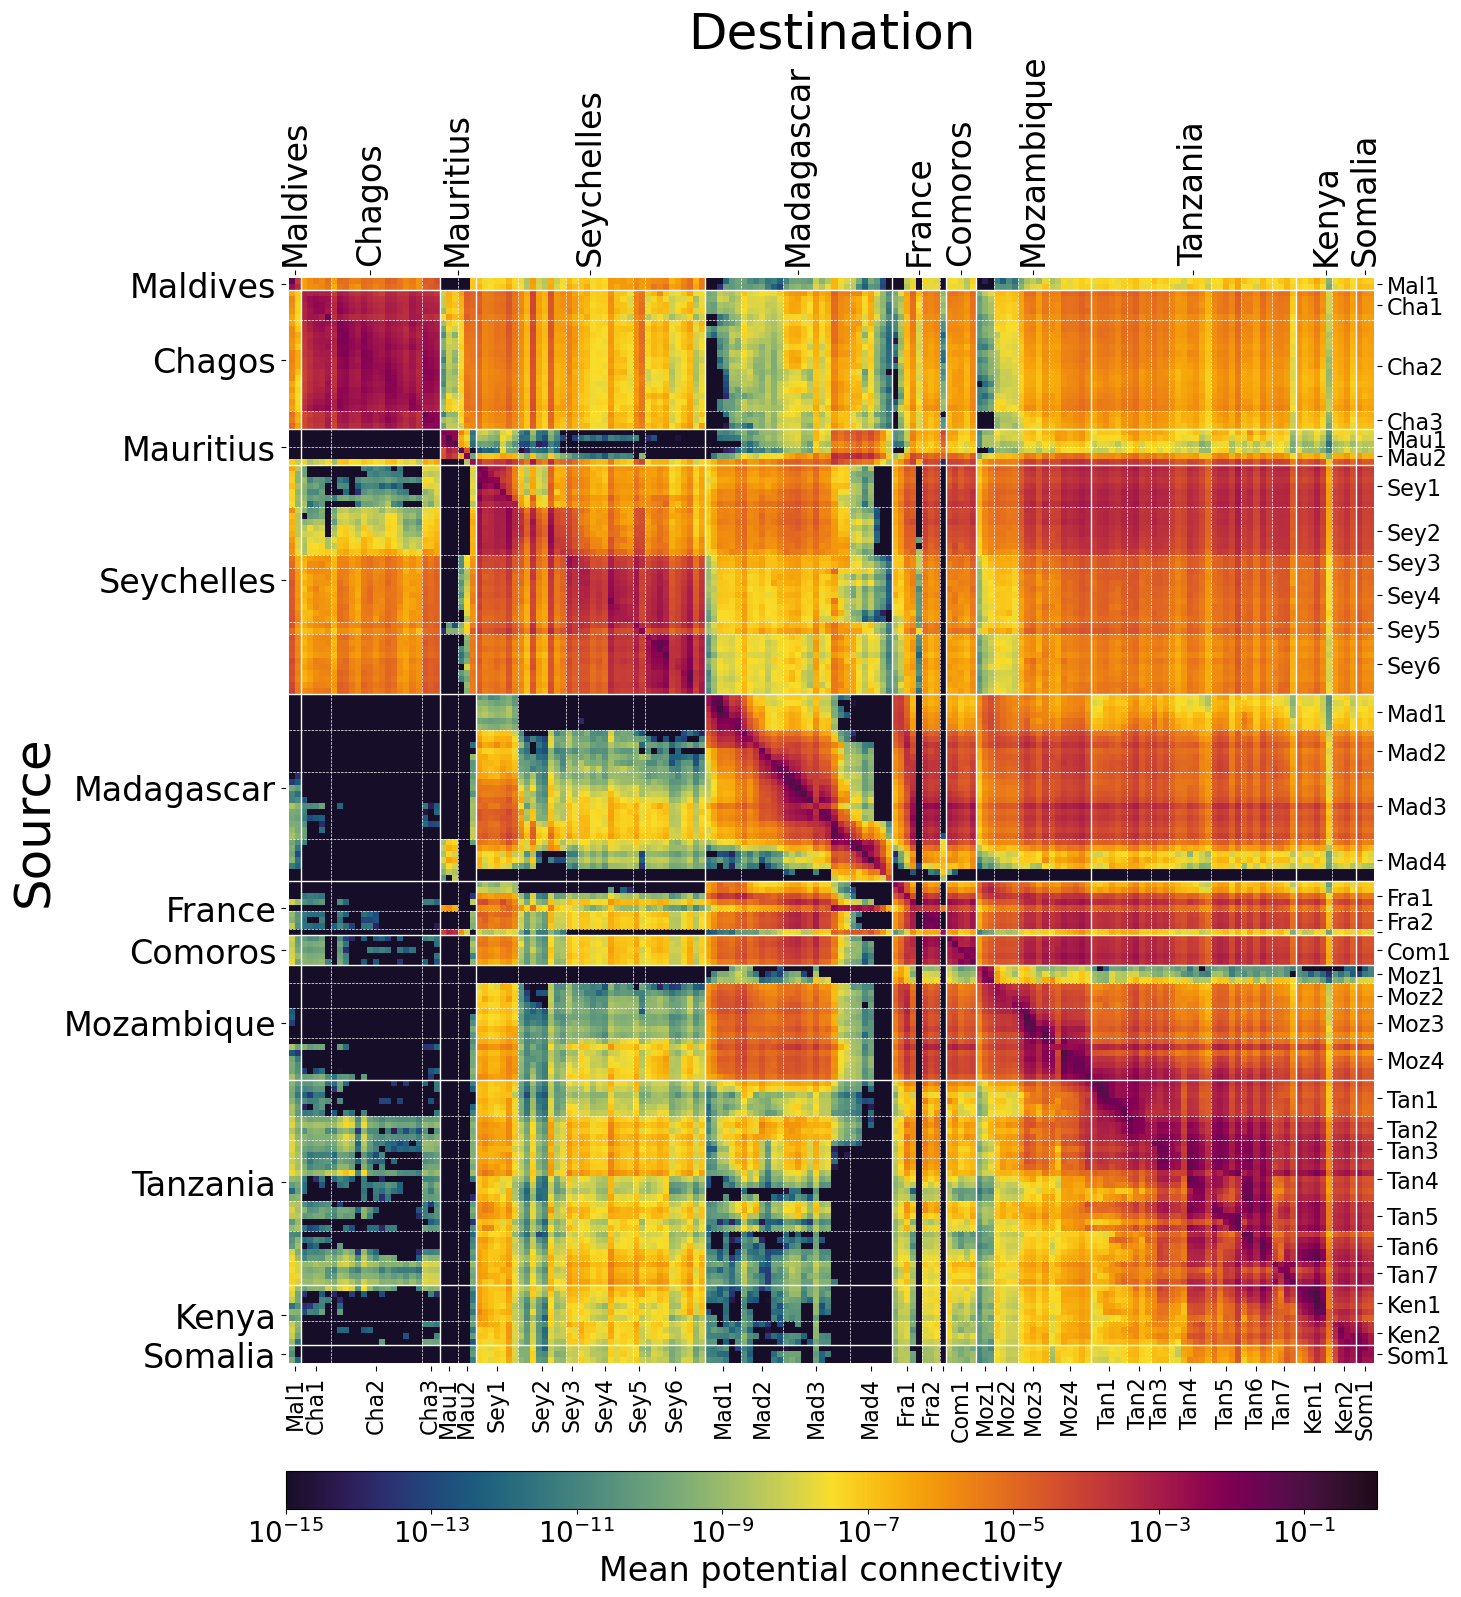

In [9]:
# Plot alternate version (full size)
f = plt.figure(constrained_layout=True, figsize=(14.5, 16.0))
gs = GridSpec(2, 1, figure=f, height_ratios=[1, 0.03], hspace=0.02)
ax = []
ax.append(f.add_subplot(gs[0, 0], zorder=2))  # Mean
ax.append(f.add_subplot(gs[0, 0], zorder=1))  # Mean (axis 2)
ax.append(f.add_subplot(gs[1, 0], zorder=1))  # Distance CB

# Plot mean data
gen_plot = ax[0].pcolormesh(axis_bnd, axis_bnd, mean_matrix,
                            norm=colors.LogNorm(
                                vmin=1e-15, vmax=1e0, clip=True),
                            cmap=cmr.pride)

for bndry in L1_border_pos:
    ax[0].plot([axis_bnd.min(), axis_bnd.max()], [
               bndry, bndry], 'w--', linewidth=0.5)
    ax[0].plot([bndry, bndry], [axis_bnd.min(),
               axis_bnd.max()], 'w--', linewidth=0.5)

for bndry in country_border_pos:
    ax[0].plot([axis_bnd.min(), axis_bnd.max()],
               [bndry, bndry], 'w-', linewidth=1)
    ax[0].plot([bndry, bndry], [axis_bnd.min(),
               axis_bnd.max()], 'w-', linewidth=1)

ax[0].set_aspect(1)
ax[0].set_facecolor('w')
ax[0].set_xticks(country_tick_pos)
ax[0].set_xticklabels(country_tick_label, rotation='vertical', fontsize=24,)
ax[0].set_yticks(country_tick_pos)
ax[0].set_yticklabels(country_tick_label, fontsize=24)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].xaxis.tick_top()
ax[0].set_xlim([0, 181])
ax[0].set_ylim([0, 181])
ax[0].invert_yaxis()
ax[0].set_xlabel('Destination', fontsize=36)
ax[0].set_ylabel('Source', fontsize=36)
ax[0].xaxis.set_label_position('top')

ax[1].set_aspect(1)
ax[1].set_xticks(L1_tick_pos)
ax[1].set_xticklabels(L1_country_tick_label, rotation='vertical', fontsize=16,)
ax[1].set_yticks(L1_tick_pos)
ax[1].set_yticklabels(L1_country_tick_label, fontsize=16)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].yaxis.tick_right()
ax[1].set_xlim([0, 181])
ax[1].set_ylim([0, 181])
ax[1].invert_yaxis()

cbar1 = plt.colorbar(gen_plot, cax=ax[2], orientation='horizontal')
cbar1.set_label('Mean potential connectivity', size=24)
cbar1.ax.tick_params(axis='x', labelsize=20)

#plt.close()

In [18]:
#plt.savefig(dirs['fig'] + bio_code +
            #'_cx_matrix_mean_labelled.pdf', bbox_inches='tight', dpi=300)
#plt.close()

# Same for CV
f = plt.figure(constrained_layout=True, figsize=(14.5, 16.0))
gs = GridSpec(2, 1, figure=f, height_ratios=[1, 0.03], hspace=0.02)
ax = []
ax.append(f.add_subplot(gs[0, 0], zorder=2))  # Mean
ax.append(f.add_subplot(gs[0, 0], zorder=1))  # Mean (axis 2)
ax.append(f.add_subplot(gs[1, 0], zorder=1))  # Distance CB

# Plot mean data
conf_plot = ax[0].pcolormesh(axis_bnd, axis_bnd, cv_matrix,
                             norm=colors.LogNorm(vmin=1e0, vmax=1e2),
                             cmap=cmr.neutral)

for bndry in L1_border_pos:
    ax[0].plot([axis_bnd.min(), axis_bnd.max()], [
               bndry, bndry], 'w--', linewidth=0.5)
    ax[0].plot([bndry, bndry], [axis_bnd.min(),
               axis_bnd.max()], 'w--', linewidth=0.5)

for bndry in country_border_pos:
    ax[0].plot([axis_bnd.min(), axis_bnd.max()],
               [bndry, bndry], 'w-', linewidth=1)
    ax[0].plot([bndry, bndry], [axis_bnd.min(),
               axis_bnd.max()], 'w-', linewidth=1)

ax[0].set_aspect(1)
ax[0].set_facecolor('w')
ax[0].set_xticks(country_tick_pos)
ax[0].set_xticklabels(country_tick_label, rotation='vertical', fontsize=24,)
ax[0].set_yticks(country_tick_pos)
ax[0].set_yticklabels(country_tick_label, fontsize=24)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].xaxis.tick_top()
ax[0].set_xlim([0, 181])
ax[0].set_ylim([0, 181])
ax[0].invert_yaxis()
ax[0].set_xlabel('Destination', fontsize=36)
ax[0].set_ylabel('Source', fontsize=36)
ax[0].xaxis.set_label_position('top')

ax[1].set_aspect(1)
ax[1].set_xticks(L1_tick_pos)
ax[1].set_xticklabels(L1_country_tick_label, rotation='vertical', fontsize=16,)
ax[1].set_yticks(L1_tick_pos)
ax[1].set_yticklabels(L1_country_tick_label, fontsize=16)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].yaxis.tick_right()
ax[1].set_xlim([0, 181])
ax[1].set_ylim([0, 181])
ax[1].invert_yaxis()

cbar1 = plt.colorbar(conf_plot, cax=ax[2], orientation='horizontal')
cbar1.set_label('Coefficient of variation', size=24)
cbar1.ax.tick_params(axis='x', labelsize=20)
plt.close()

In [ ]:
#plt.savefig(dirs['fig'] + bio_code +
            '_cx_matrix_cv_labelled.pdf', bbox_inches='tight', dpi=300)

# Export to netcdf
mean_matrix.name = 'single_step_explicit_mean'
cv_matrix.name = 'single_step_explicit_cv'
gen_dist_median.name = 'gen_dist_median'
gen_dist_variance.name = 'gen_dist_mod_cv'

output_matrix = xr.merge([mean_matrix, cv_matrix, gen_dist_median, gen_dist_variance]).drop('quantile')
output_matrix.to_netcdf(dirs['matrix'] + bio_code + '_processed_connectivity_matrices.nc',
                        encoding={var: {'zlib': True, 'complevel': 5} for var in output_matrix.variables})